In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [87]:
df=pd.read_csv("titanicTrain.csv")
# df.info()
df=df.dropna(axis=0, how='all').dropna(axis=1, how='all')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 14 columns):
pclass       1000 non-null float64
survived     1000 non-null float64
name         1000 non-null object
sex          1000 non-null object
age          861 non-null float64
sibsp        1000 non-null float64
parch        1000 non-null float64
ticket       1000 non-null object
fare         1000 non-null float64
cabin        283 non-null object
embarked     998 non-null object
boat         417 non-null object
body         95 non-null float64
home.dest    742 non-null object
dtypes: float64(7), object(7)
memory usage: 117.2+ KB


([<matplotlib.axis.XTick at 0x296e935f588>,
 <a list of 2 Text xticklabel objects>)

c:\users\alixh\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft JhengHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


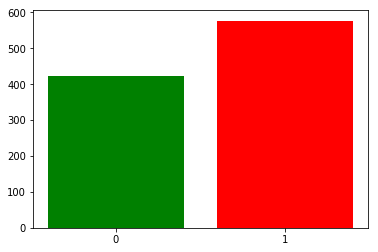

In [4]:
all_survive=len(df[df["survived"]==1])
all_dead=len(df[df["survived"]==0])
x=np.arange(2)
plt.bar(x,[all_survive,all_dead],align='center',color="g" "r")
plt.xticks(x, ("0","1"))

影響參數：plcass、name、sex、age、sibsp、parch、ticket、fare、cabin、embarked、boat、body、home.dest

## 1. 先進行參數的有效化

發現有缺的是age、cabin、embarked、boat、body、home.dest，先從缺的比較少的去做(有先嘗試過先做cabin，但是誤差很大)

### (1) embarked

可以觀察到，含船艙位置有密切的關係

In [89]:
print(len(df[df["embarked"]=="S"]["cabin"])+len(df[df["embarked"]=="C"]["cabin"])+len(df[df["embarked"]=="Q"]["cabin"]))

998


In [91]:
print(set(df[df["embarked"]=="S"]["cabin"]) & set(df[df["embarked"]=="C"]["cabin"]))
print(set(df[df["embarked"]=="S"]["cabin"]) & set(df[df["embarked"]=="Q"]["cabin"]))
print(set(df[df["embarked"]=="Q"]["cabin"]) & set(df[df["embarked"]=="C"]["cabin"]))

{nan, 'B51 B53 B55', 'D'}
{nan, 'E101'}
{nan, 'C78'}


In [96]:
for index,ele in enumerate(df["embarked"]):
    try:
        float(ele)
        print(df["cabin"][index])
    except:
        pass

B28
B28


In [104]:
df[df["cabin"]=="B28"]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
168,1.0,1.0,"Icard, Miss. Amelie",female,38.0,0.0,0.0,113572,80.0,B28,NaN,6,NaN,NaN
284,1.0,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0.0,0.0,113572,80.0,B28,NaN,6,NaN,"Cincinatti, OH"


In [114]:
df[df["home.dest"]=="Cincinatti, OH"]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
284,1.0,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0.0,0.0,113572,80.0,B28,NaN,6,NaN,"Cincinatti, OH"


In [107]:
df[df["ticket"]=="113572"]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
168,1.0,1.0,"Icard, Miss. Amelie",female,38.0,0.0,0.0,113572,80.0,B28,NaN,6,NaN,NaN
284,1.0,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0.0,0.0,113572,80.0,B28,NaN,6,NaN,"Cincinatti, OH"


In [112]:
print(len(df[df["embarked"]=="S"]))
print(len(df[df["embarked"]=="C"]))
print(len(df[df["embarked"]=="Q"]))

703
224
71


In [118]:
df["embarked"][168]="S"
df["embarked"][284]="S"

c:\users\alixh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\alixh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 14 columns):
pclass       1000 non-null float64
survived     1000 non-null float64
name         1000 non-null object
sex          1000 non-null object
age          861 non-null float64
sibsp        1000 non-null float64
parch        1000 non-null float64
ticket       1000 non-null object
fare         1000 non-null float64
cabin        283 non-null object
embarked     1000 non-null object
boat         417 non-null object
body         95 non-null float64
home.dest    742 non-null object
dtypes: float64(7), object(7)
memory usage: 157.2+ KB


### (2) cabin

由資料發現，坐哪一個船艙和船票有很大的關聯

In [73]:
import numpy as np
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [71]:
df_interesting=df.ix[:,["cabin","fare"]].dropna(axis=0, how='any')
allfare=list(set(df_interesting["fare"]))
dic={}
for ele in allfare:
    temp=list(df_interesting[df_interesting["fare"]==ele]["cabin"])
    dic[ele]=temp
dic_key=dic.keys()
dic_key=list(dic_key)
dic_key=np.asarray(dic_key)

for index,ele in enumerate(df["fare"]):
    if type(df["cabin"][index])==float:
        nearest=find_nearest(dic_key,ele)
        guess=random.choice(dic[nearest])
        df["cabin"][index]=guess
        print("done")

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 14 columns):
pclass       1000 non-null float64
survived     1000 non-null float64
name         1000 non-null object
sex          1000 non-null object
age          861 non-null float64
sibsp        1000 non-null float64
parch        1000 non-null float64
ticket       1000 non-null object
fare         1000 non-null float64
cabin        1000 non-null object
embarked     998 non-null object
boat         417 non-null object
body         95 non-null float64
home.dest    742 non-null object
dtypes: float64(7), object(7)
memory usage: 157.2+ KB
